# Examples for SRP Exercises

In [1]:
!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum


Cloning into 'SRP2021'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 49 (delta 9), reused 31 (delta 3), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [2]:
# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise


# Visualizing sounds with spectrograms

Here goes a little visualization tool where the participant can change the audio file and inspect the waveform and spectrogram

In [7]:
 def widget_visualize(audioFile):
    # Load file
    global x
    global fs
    global X
    global stft

    x,fs = soundfile.read(audioDir+audioFile)

    if np.ndim(x) != 1:
      x = x[:,0]

    # Normalize
    x = processing.normalize(level=65).transform(x)

    # STFT
    stft = spectrum.STFT(fs=fs)
    X = stft.transform(x)

    # Plot
    plt.figure(figsize=(10,7))
    plt.subplot(212)
    plt.pcolormesh(stft.t,stft.f,20*np.log(np.abs(X)),shading='auto',vmin=0,vmax=120)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram")
    #plt.ylim((100,8000))
    #plt.yscale('log')
    plt.subplot(211)
    plt.plot(np.arange(len(x))/fs,x)
    plt.title("Waveform")
    plt.ylabel("Level")
    plt.xlabel("Time [s]")

    plt.tight_layout()

    # Play
    display(utils.play(x,fs))


# Creating widget
audioDir = '/content/SRP2021/Audio/'
audioFiles = [f for f in os.listdir(audioDir) if f.endswith('wav')]

interactive_plot = interactive(widget_visualize,
                               audioFile=widgets.Dropdown(options=audioFiles),
                               continous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(Dropdown(description='audioFile', options=('8_lucas_27.wav', '5_lucas_27.wav', '9_lucas_…

### Questions:

- What are the differences between the timeseries representation compared to the spectrogram?
- What would a flute sound look like, compared to a cymbal? 
- What are the differences between a male and female talker? (I supply them with a sentence spoken by both a male and female)

- How are vowel sounds different from consonant sounds?


# Interferring tones and noises

We supply them with some sounds where an interferring tone is present. The participants use the visualization tool to find out what frequency the interferring tone has.

The interferring tone could also be bandlimited noise (high-pass, low-pass, and band-pass filtered)

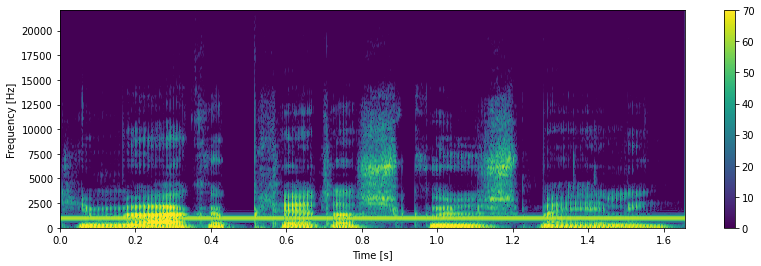

In [8]:
xsin = interferringTone(x,fs,freq=1000,level_dB=60)
y = xsin + x
Y = stft.transform(y,inv=False)

# Plot
plt.figure(figsize=(14,4))
plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(Y)),shading='auto',vmin=0,vmax=70)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar()

display(utils.play(y,fs))




# Filtering

next goal is to remove the interferring noise by using high-pass, low-pass, and bandpass filtering.
The filter is designed as a gainmask that is multiplied to the STFT representation of the sound

The participant gets controls for the filter type and the cutoff frequencies.



In [9]:
def widget_filtering(frequency,f_width):
  fIdx = np.argmin(np.abs(frequency-stft.f))

  # Create a gain mask
  GainMask = np.ones_like(Y).real
  GainMask[fIdx-f_width:fIdx+f_width,:] *= 0.01

  # Multiply in STFT domain
  X_hat = Y*GainMask

  # Inverse STFT
  x_hat = stft.transform(X_hat,inv=True)


  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(Y)),shading='auto',vmin=0,vmax=70)
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.title("Input")

  plt.subplot(132)
  plt.pcolormesh(stft.t,stft.f,GainMask,shading='auto')
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.colorbar()
  plt.title("Gain")

  plt.subplot(133)
  plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(X_hat)),shading='auto',vmin=0,vmax=70)
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.title("Output")

  plt.tight_layout()
  plt.show()

  print("Input:")
  display(utils.play(y,fs))

  print("Output")
  display(utils.play(x_hat,fs))

  print("Ideal")
  display(utils.play(stft.transform(X,inv=True),fs))

interactive_plot = interactive(widget_filtering,
                               frequency=widgets.IntSlider(value=200,min=50,max=4000,step=50),
                               f_width=widgets.IntSlider(value=1,min=1,max=20,step=1),
                               continous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=200, description='frequency', max=4000, min=50, step=50), IntSlider(valu…

### Questions for the participants:

- How does the gain mask work?
- How does the output sound compared to the input?

- How does the output sound compared to the original soundfile without the interferrer?
    - What happens when the bandwidth is too narrow?
    - What happens when it's too wide?



- Can you imagine any real life scenarios where this technique is beneficial? 


### Possible measures:
I could supply them with these metrics
- SNR
- Reconstruction error


## Thresholding exercise

Similar to before, but now theres a broadband noise instead of narrowband noise/tones


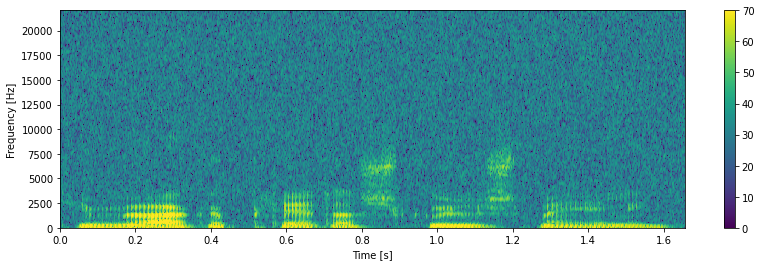

In [10]:
x_noise = interferringNoise(x,fs,SNR=15)
y = x + x_noise
Y = stft.transform(y,inv=False)
utils.play(y,fs)

# Plot
plt.figure(figsize=(14,4))
plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(Y)),shading='auto',vmin=0,vmax=70)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar()

display(utils.play(y,fs))




In [12]:
def widget_thresholding(threshold):

  # Create a gain mask
  GainMask = (10*np.log10(np.abs(Y)) > threshold)*1

  # Multiply in STFT domain
  X_hat = Y*GainMask

  # Inverse STFT
  x_hat = stft.transform(X_hat,inv=True)


  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(Y)),shading='auto',vmin=0,vmax=70)
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.title("Input")

  plt.subplot(132)
  plt.pcolormesh(stft.t,stft.f,GainMask,shading='auto')
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.colorbar()
  plt.title("Gain")

  plt.subplot(133)
  plt.pcolormesh(stft.t,stft.f,10*np.log(np.abs(X_hat)+1e-99),shading='auto',vmin=0,vmax=70)
  plt.xlabel("Time [s]")
  plt.ylabel("Frequency [Hz]")
  plt.title("Output")

  plt.tight_layout()
  plt.show()

  print("Input:")
  display(utils.play(y,fs))

  print("Output")
  display(utils.play(x_hat,fs))

  print("Ideal")
  display(utils.play(stft.transform(X,inv=True),fs))

interactive_plot = interactive(widget_thresholding,
                               threshold=widgets.IntSlider(value=0,min=0,max=40,step=1),
                               continous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=0, description='threshold', max=40), Output(layout=Layout(height='600px'…